In [1]:
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD  
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')

Modules loaded


In [2]:
dataset_path = "H:/MangoBD"

filepaths = []
labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            filepaths.append(file_path)
            labels.append(class_name)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Split 80%, 10%, 10%
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Data augmentation for validation and test (only normalization)
valid_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

batch_size = 12

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(227, 227),  
    batch_size=batch_size,
    class_mode='categorical'
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(227, 227),  
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(227, 227), 
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3200 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

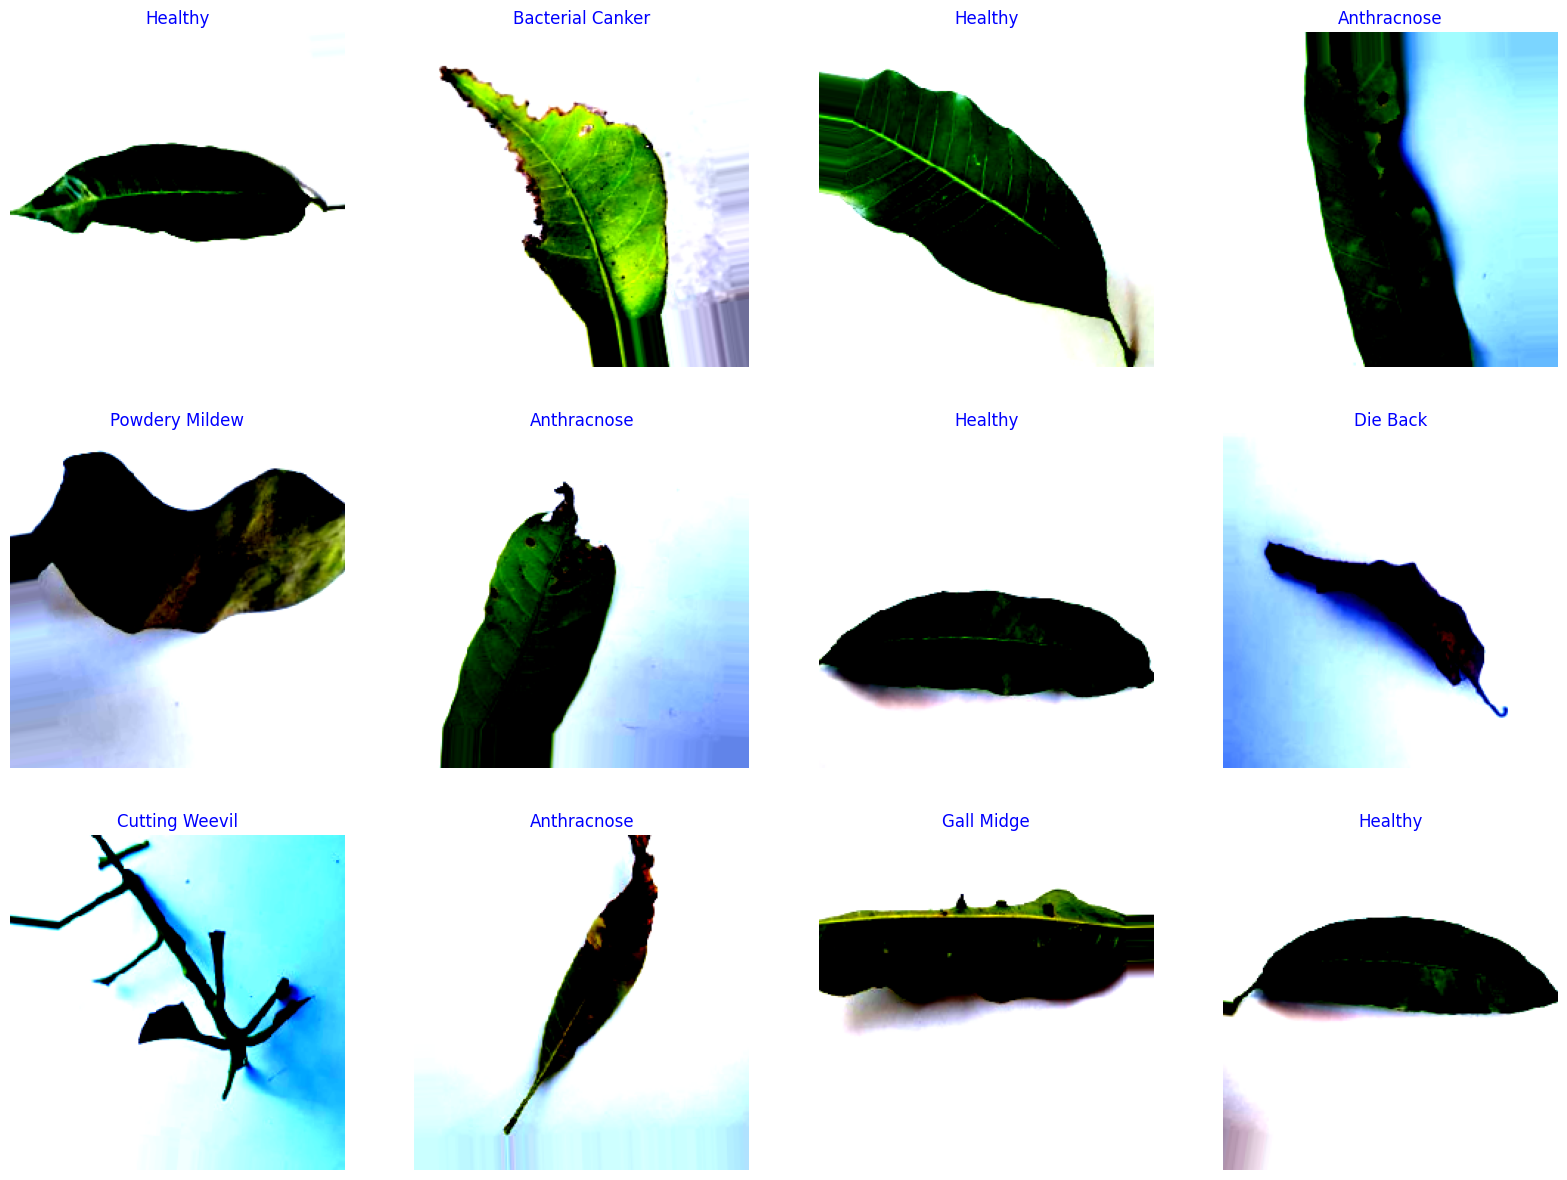

In [3]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

batch_size = len(images) 

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]  
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

In [4]:
model = Sequential()

# Input layer: Convolutional layer
model.add(Conv2D(64, (7, 7), strides=(2, 2), input_shape=(227, 227, 3)))  
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Convolutional layer 2
model.add(Conv2D(128, (5, 5), strides=(1, 1)))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# MaxPooling layer 1
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Convolutional layer 3
model.add(Conv2D(256, (3, 3), strides=(1, 1)))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Convolutional layer 4
model.add(Conv2D(512, (3, 3), strides=(1, 1)))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# Convolutional layer 5
model.add(Conv2D(512, (3, 3), strides=(1, 1)))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

# MaxPooling layer 2
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Convolutional layer 6
model.add(Conv2D(256, (3, 3), strides=(1, 1)))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))

model.add(Flatten())

# Fully connected layer 1
model.add(Dense(512))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.3)) 

# Fully connected layer 2 (Output layer with 8 classes for softmax)
model.add(Dense(8, activation='softmax'))

custom_learning_rate = 0.0001  

custom_optimizer = SGD(learning_rate=custom_learning_rate)

model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 111, 111, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 111, 111, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 128)     204928    
                                                                 
 batch_normalization_1 (Batc  (None, 107, 107, 128)    512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 107, 107, 128)     0

In [5]:
epochs = 100  
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=valid_gen,
    validation_steps=len(valid_gen),
    epochs=epochs
)

Epoch 1/100
267/267 [==============================] - 47s 145ms/step - loss: 1.5592 - accuracy: 0.4494 - val_loss: 1.8741 - val_accuracy: 0.3150
Epoch 2/100
267/267 [==============================] - 35s 131ms/step - loss: 0.9028 - accuracy: 0.6762 - val_loss: 0.5602 - val_accuracy: 0.8050
Epoch 3/100
267/267 [==============================] - 35s 132ms/step - loss: 0.6810 - accuracy: 0.7725 - val_loss: 0.4474 - val_accuracy: 0.8500
Epoch 4/100
267/267 [==============================] - 35s 131ms/step - loss: 0.5618 - accuracy: 0.8141 - val_loss: 0.4674 - val_accuracy: 0.8450
Epoch 5/100
267/267 [==============================] - 35s 132ms/step - loss: 0.5059 - accuracy: 0.8278 - val_loss: 0.2679 - val_accuracy: 0.9025
Epoch 6/100
267/267 [==============================] - 35s 132ms/step - loss: 0.4312 - accuracy: 0.8606 - val_loss: 0.2869 - val_accuracy: 0.9000
Epoch 7/100
267/267 [==============================] - 35s 131ms/step - loss: 0.4451 - accuracy: 0.8506 - val_loss: 0.2557 -

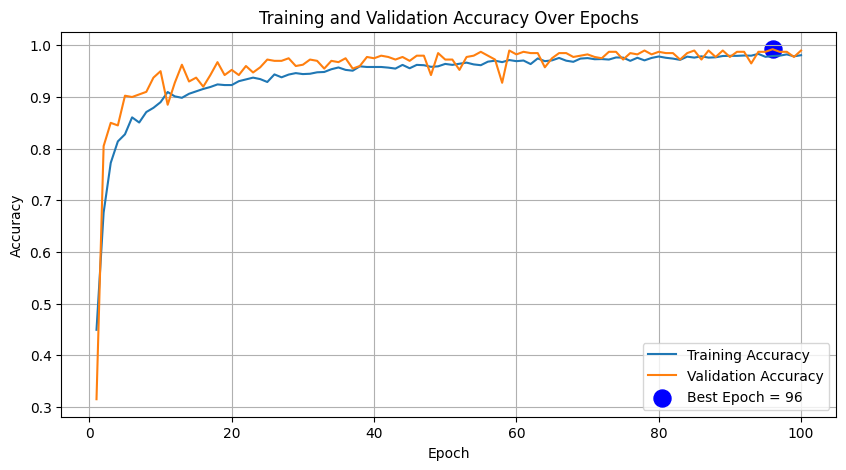

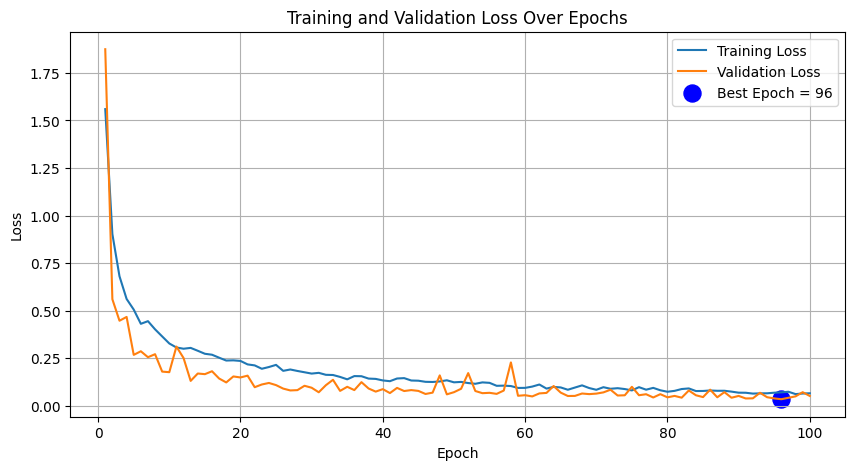

In [6]:
import os
import matplotlib.pyplot as plt

tr_loss = history.history['loss']
tr_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

epochs = range(1, len(tr_loss) + 1)
loss_label = f'Best Epoch = {index_loss + 1}'
acc_label = f'Best Epoch = {index_acc + 1}'

#accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, tr_acc, label='Training Accuracy', linestyle='-')
plt.plot(epochs, val_acc, label='Validation Accuracy', linestyle='-')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.grid(True)
plt.show()

#loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, tr_loss, label='Training Loss', linestyle='-')
plt.plot(epochs, val_loss, label='Validation Loss', linestyle='-')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)
plt.show()


In [7]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 0s 46ms/step - loss: 0.0050 - accuracy: 1.0000
Train Loss:  0.02744155563414097
Train Accuracy:  0.9833333492279053
--------------------
Validation Loss:  0.011361400596797466
Validation Accuracy:  1.0
--------------------
Test Loss:  0.0050468770787119865
Test Accuracy:  1.0


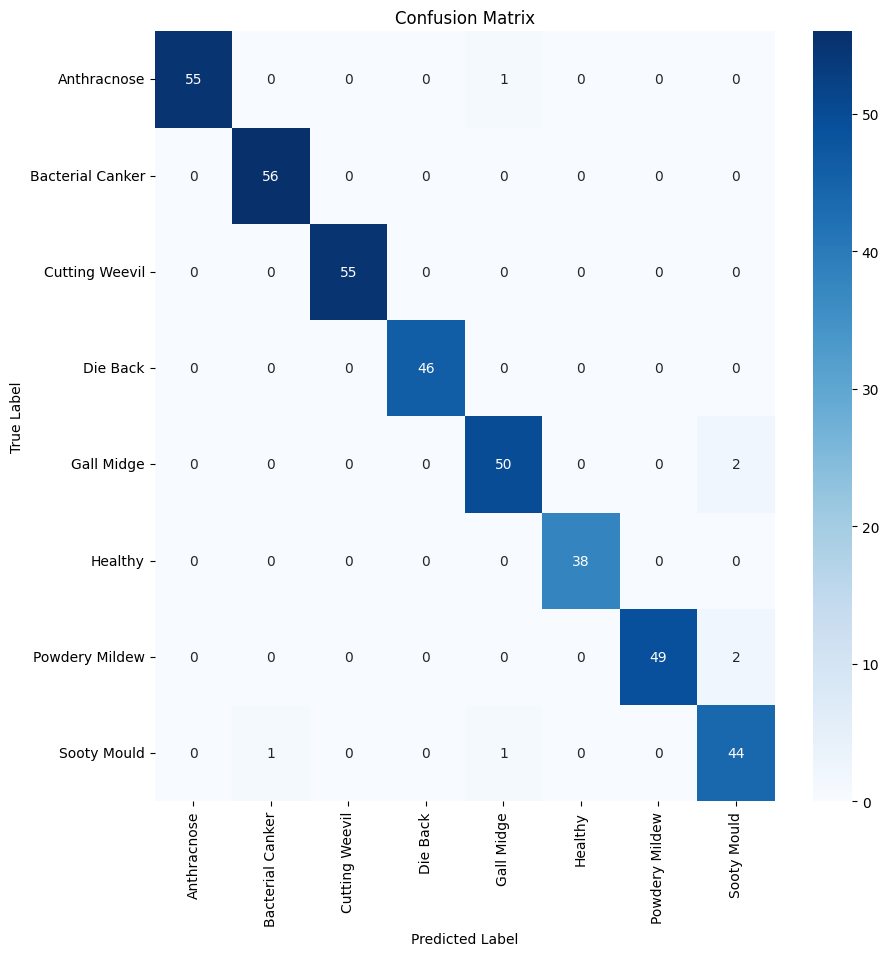

In [8]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()

In [9]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       1.00      0.98      0.99        56
Bacterial Canker       0.98      1.00      0.99        56
  Cutting Weevil       1.00      1.00      1.00        55
        Die Back       1.00      1.00      1.00        46
      Gall Midge       0.96      0.96      0.96        52
         Healthy       1.00      1.00      1.00        38
  Powdery Mildew       1.00      0.96      0.98        51
     Sooty Mould       0.92      0.96      0.94        46

        accuracy                           0.98       400
       macro avg       0.98      0.98      0.98       400
    weighted avg       0.98      0.98      0.98       400



34/34 [==============================] - 1s 43ms/step
Class 0 - AUC: 1.00
Class 1 - AUC: 1.00
Class 2 - AUC: 1.00
Class 3 - AUC: 1.00
Class 4 - AUC: 1.00
Class 5 - AUC: 1.00
Class 6 - AUC: 1.00
Class 7 - AUC: 1.00


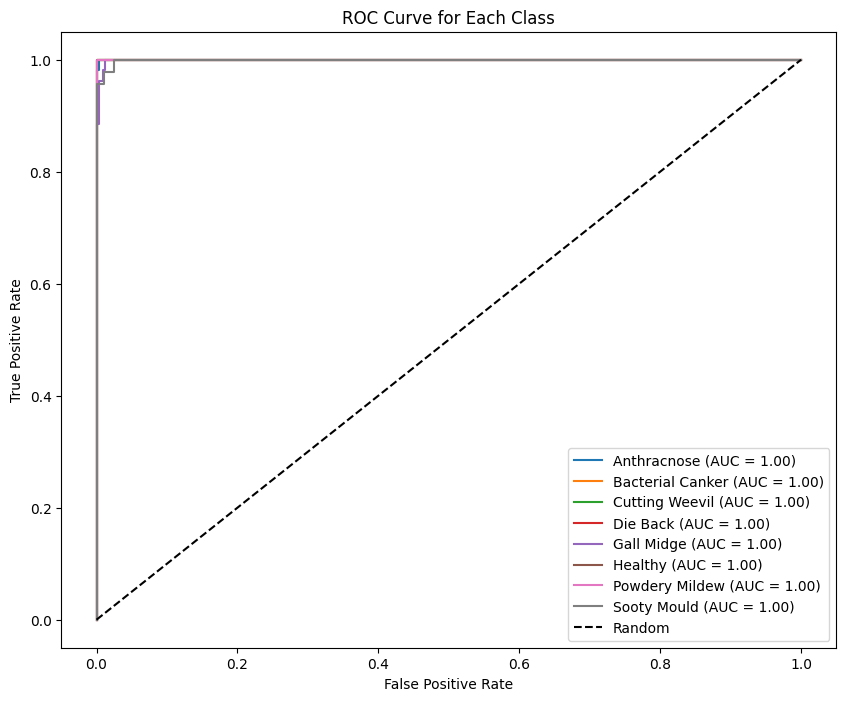

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Define the number of classes
num_classes = len(train_gen.class_indices)

# Generate predictions for the entire test set
y_pred_prob = model.predict_generator(test_gen, steps=len(test_gen), verbose=1)

# Convert labels to one-hot encoding
y_true = label_binarize(test_gen.classes, classes=range(num_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f'Class {i} - AUC: {roc_auc[i]:.2f}')

# Plot the ROC curve
plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

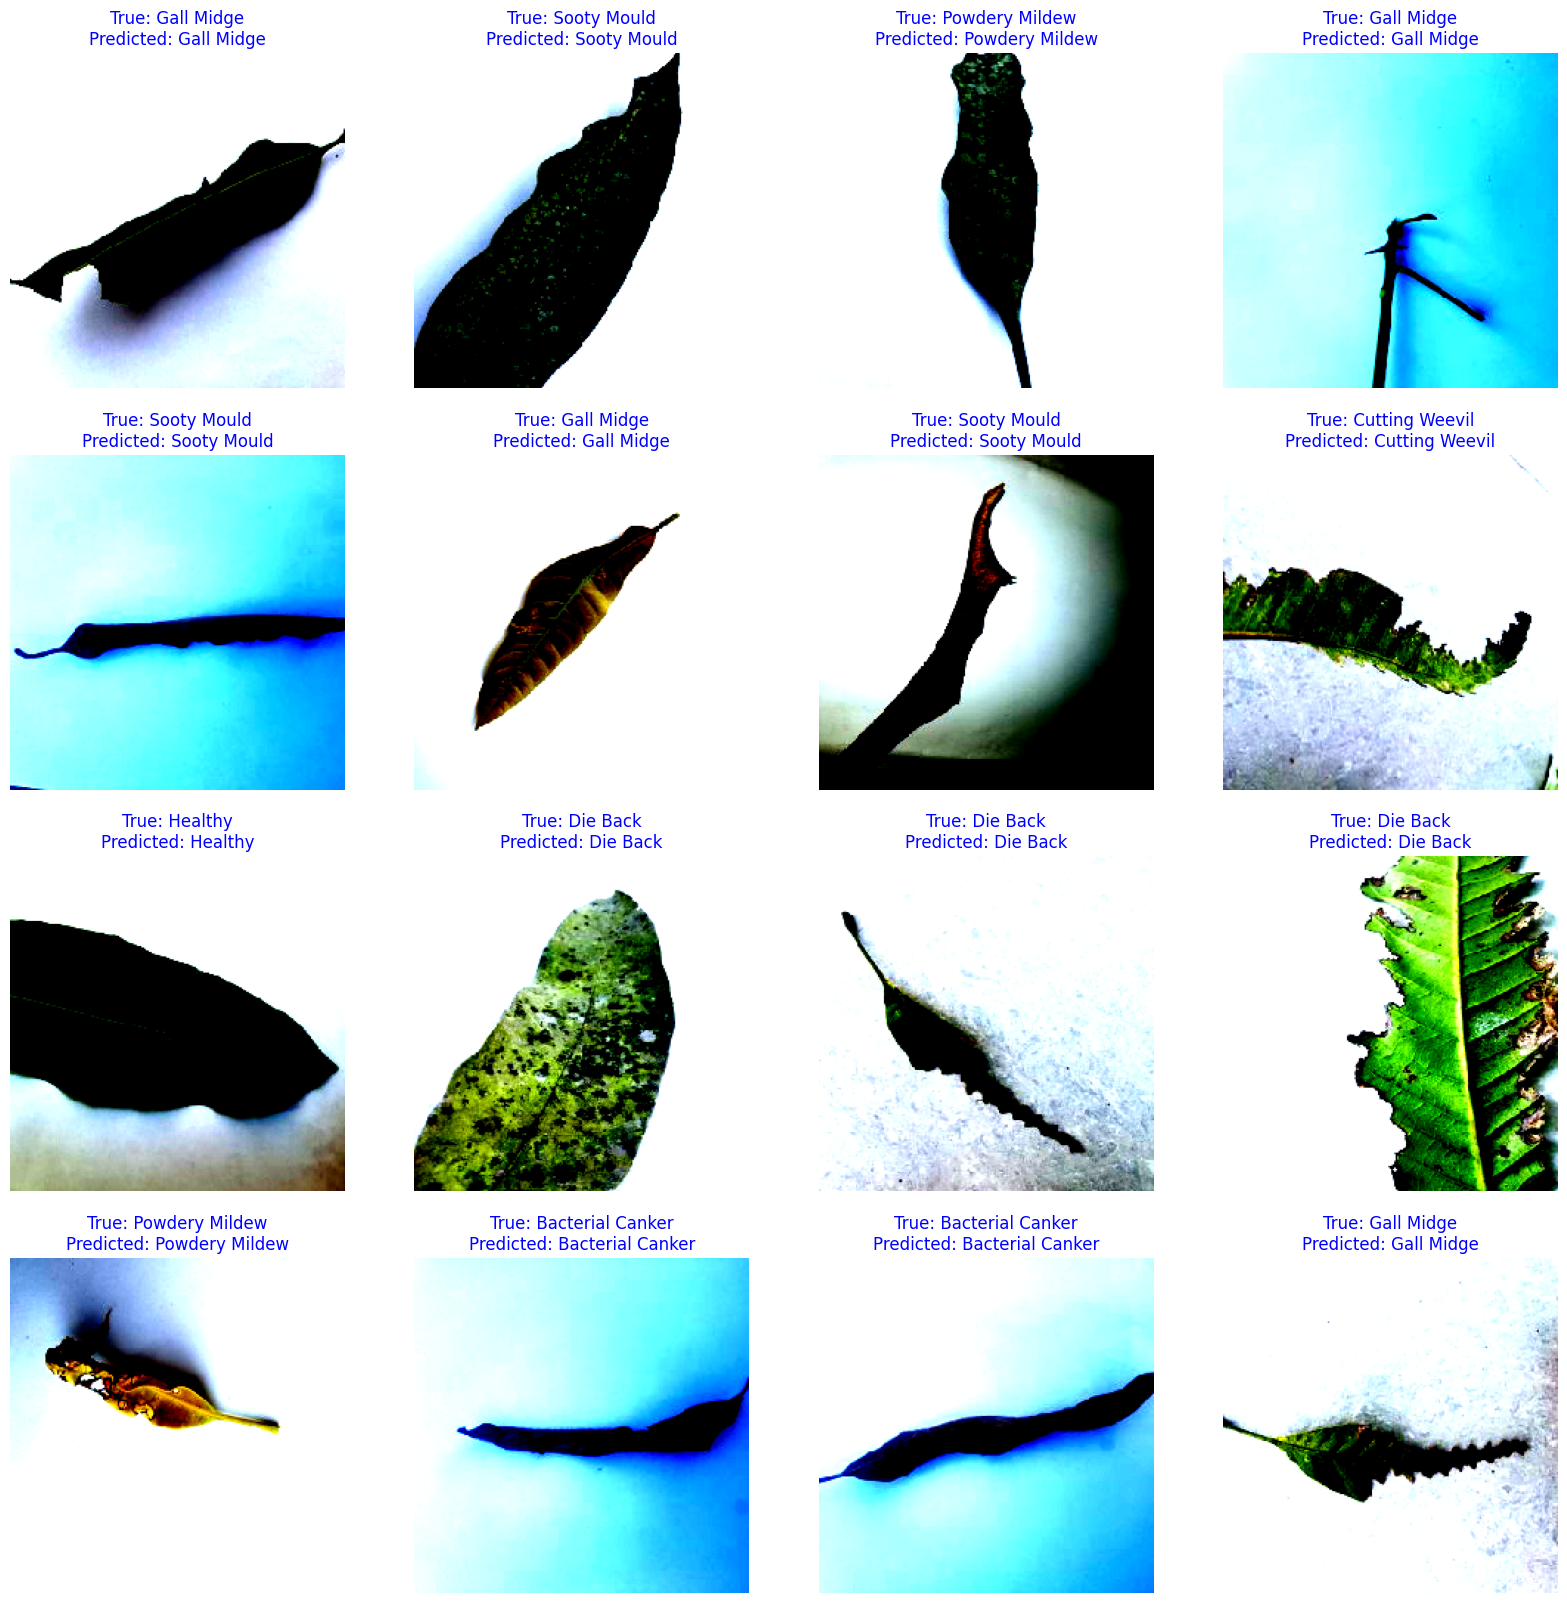

In [11]:
# Generate predictions for the entire test set
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

# True labels
true_labels = test_gen.classes

# Display a few images with true and predicted labels
plt.figure(figsize=(20, 20))

for i in range(16):  # Displaying the first 16 images
    plt.subplot(4, 4, i + 1)
    image = test_gen[i][0][0]  # Get the image from the batch
    true_label = classes[true_labels[i]]
    pred_label = classes[y_pred[i]]

    plt.imshow(image)
    plt.title(f'True: {true_label}\nPredicted: {pred_label}', color='blue', fontsize=12)
    plt.axis('off')

plt.show()
